In [1]:
import bokeh
import numpy as np
from bokeh.plotting import figure, show
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
import bs4 as bs
import pickle
import requests
import datetime as dt
import os, glob
import pandas as pd
import pandas_datareader.data as web
import pandas_datareader as pdr
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing


In [4]:
sns.set(color_codes=True)

##### We first need to get the stock data and putting them into a dataframe

In [1]:
ticker=['MSFT','AAPL','GOOGL','TSLA','AMZN','CCL','EBAY','FB','UPS','USB','TWTR','PYPL','HON','SO','PG','NKE']
days = [5,20]
def get(t:ticker):
    def data(ticker):
        return (pdr.DataReader(ticker,'yahoo',start="2019-01-01"))
    datas = map (data, ticker)
    return(pd.concat(datas, keys=ticker, names=['Ticker', 'Date']))
df=get(ticker)

#SIMPLE MOVING AVERAGE
def SMA(df, days): 
    sma = df['Close'].rolling(days).mean()
    sma = pd.Series(sma, name = 'SMA_' + str(days ))
    df = df.join(sma, how='right') 
    return df

#EXPONENTIALLY-WEIGHTED-MOVING AVERAGE
def EWMA(df, days):
    ema = pd.Series(df['Close'].ewm(span=days,  min_periods = days - 1).mean(), 
    name = 'EWMA_' + str(days))
    df = df.join(ema) 
    return df

    
#BOLLINGER BANDS (UpperBB & LowerBB)
def bbands(df, window=days):
    MA = df.Close.rolling(window=days).mean()
    SD = df.Close.rolling(window=days).std()
    df['UpperBB'] = MA + (2 * SD) 
    df['LowerBB'] = MA - (2 * SD)
    df['Percent_B']=(df['Close'] - df['LowerBB'])/(df['UpperBB'] - df['LowerBB'])
    return df
# Rate of Change (ROC)
def ROC(df,days):
    N = df['Close'].diff(days)
    D = df['Close'].shift(days)
    roc= N/D
    roc = pd.Series(roc, name='ROC'+str(days))
    df = df.join(roc)
    return df
days_list = [5,20] 
for days in days_list:
    df = SMA(df,days)
    df = EWMA(df,days)
    df= ROC(df,days)
    df= bbands(df,window=days)

df=df.dropna()


NameError: name 'pd' is not defined

#### Lets see the correlation of the parameters

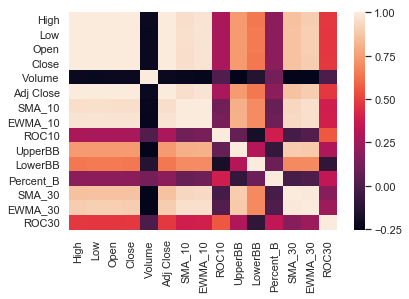

In [48]:
sns.heatmap(df.corr())

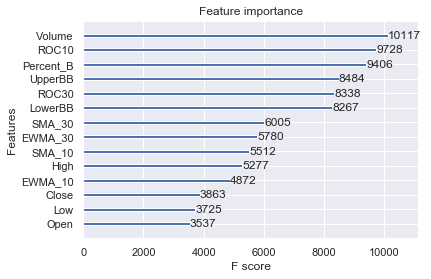

In [53]:
X=df.drop("Adj Close", axis=1)
y=df["Adj Close"]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.50)

model = XGBClassifier()
model.fit(X, y)
# plot feature importance
plot_importance(model)
pyplot.show()

4

###### It takes time to load the feautures due to large data

In [ ]:
preds=model.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

In [55]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)
params = {"booster":"gblinear", "objective":"reg:linear"}
xg_reg = xgb.train(params = params, dtrain=DM_train, num_boost_round=5) # Train the model
pred = xg_reg.predict(DM_test) # Predict the labels of the test set


/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


##### Implementing the regression models

In [56]:
clf = XGBRegressor()
clf.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [57]:
param_grid = {
    "n_estimators": [100, 120, 140, 150],
    "base_score": [0.3, 0.4, 0.5, 0.6]
}

clf_gs = RandomizedSearchCV(clf, param_grid, cv=5, n_iter=3)
res = clf_gs.fit(X_train, y_train)
res.best_params_

/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
 

{'n_estimators': 120, 'base_score': 0.3}

In [58]:
scaler = preprocessing.StandardScaler()
clf = XGBRegressor(objective='reg:linear',n_estimators=res.best_params_['n_estimators'],
                  base_score=res.best_params_['base_score'],)
clf.fit(X_train, y_train)
#y_pred= clf.predict(X_test)
#clf.score(X_test,y_test)
pipe= Pipeline([("scaler",preprocessing.StandardScaler()),("clf", XGBRegressor())])
pipe.fit(X_train, y_train)
y_pred_p = pipe.predict(X_test)

y_pred_p

/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


array([ 151.95601 ,  164.58995 ,   49.42558 ,  159.07797 , 1770.3855  ,
        149.18889 ,  151.91515 ,   87.1094  ,  113.682205,   97.69316 ,
         36.405087,  344.3313  ,   32.711826,   34.54984 , 1861.07    ,
        100.27399 ,  272.34348 , 1116.4843  ,  164.58995 ,  316.90244 ,
         94.725876, 1619.6948  ,  112.44035 ,   36.674984,  140.89198 ,
        100.33183 , 1670.3712  ,  170.73271 ,  272.26364 ,   90.87389 ,
        100.27399 ,  148.1025  ,   95.4769  ,  100.906906,   59.558456,
         32.613514,  104.25289 ,   90.87389 ,  107.63444 ,  173.74869 ,
         46.1221  ,   50.67726 ,   35.09954 , 1571.907   ,  119.63916 ,
        140.89198 ,   51.214214,  172.2478  ,  100.96475 , 1595.1581  ,
        178.42416 ,   34.640915, 1079.5411  ,   47.585453,   84.730965,
        187.87433 , 1153.5258  ,  170.73271 ,  277.39618 ,  277.22168 ,
        265.61923 ,   32.909946,   35.726658, 1695.1967  ,   94.73865 ,
         91.07528 ,   84.70004 ,  151.93227 ,   33.94656 ,  156.

##### Here I will try to visualize the correlation of each stock based on daily returns 

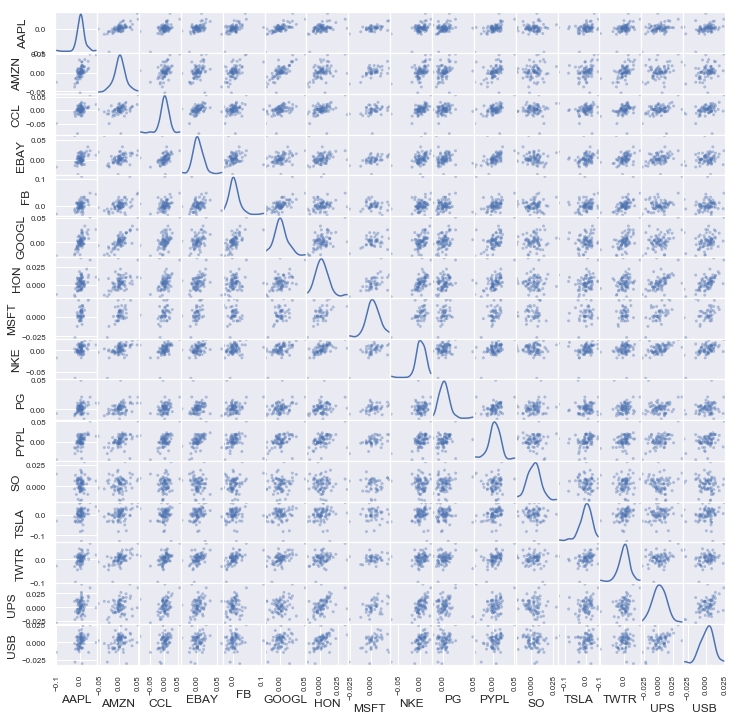

         Adj Close
count  1170.000000
mean      0.010603
std       0.212424
min      -0.973451
25%      -0.004513
50%       0.002410
75%       0.009928
max       4.632474


In [59]:
daily_close = df[['Adj Close']]
daily_pct = daily_close.pct_change()
daily_pct.fillna(0, inplace=True)
daily_close_t = df[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')
daily_pct_change = daily_close_t.pct_change()
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.4,figsize=(12,12))
plt.show()
print(daily_pct.describe())
cum_daily_return = (1 + daily_pct).cumprod()
#cum_daily_return

In [6]:
df=df.reset_index(level=['Ticker'])

In [7]:
short_window = 10
long_window = 30

##### I tried to pass the recommended features,found by the classifier, to my algorithm yet I could not manage to do it that is why I used to technical indicators that I defined at the beginnning instead.

In [8]:
def algo(df):
    signals = pd.DataFrame(index=df.index)
    signals['long_ew'] = df['EWMA_30']
    signals['UpperBB']=df['UpperBB']
    signals['LowerBB']=df['LowerBB']
    signals['Percent_B']=df['Percent_B']
    signals['short_mavg'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
    signals['Tickers']=df['Ticker']
    signals['signal'] = 0.0
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] \
             > signals['long_mavg'][short_window:], 1.0, 0.0)
    signals['signal'][short_window:]= np.where((signals['Percent_B'][short_window:] <=.2),1,0)
    signals['positions'] = signals['signal'].diff()
    df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Strategy Return'] = df['Market Return'] * signals['positions']  
    return signals
signals=algo(df)
signals

/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/Users/Kantemirovs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,long_ew,UpperBB,LowerBB,Percent_B,short_mavg,long_mavg,Tickers,signal,positions
Date,,,,,,,,,
2019-02-14,105.422729,109.248635,100.370031,0.735473,106.900002,106.900002,MSFT,0.0,NaN
2019-02-15,105.627424,108.803384,101.536615,0.919719,107.560001,107.560001,MSFT,0.0,0.0
2019-02-19,105.811883,108.957929,101.798070,0.889952,107.763334,107.763334,MSFT,0.0,0.0
2019-02-20,105.908187,108.955213,102.140120,0.735116,107.610001,107.610001,MSFT,0.0,0.0
2019-02-21,106.158349,109.293162,102.242838,1.016573,107.970001,107.970001,MSFT,0.0,0.0
2019-02-22,106.499719,109.946505,102.036161,1.129387,108.470001,108.470001,MSFT,0.0,0.0
2019-02-25,106.858549,110.603304,101.912029,1.113527,108.915715,108.915715,MSFT,0.0,0.0
2019-02-26,107.244060,111.261595,101.891071,1.117219,109.346251,109.346251,MSFT,0.0,0.0
2019-02-27,107.587334,111.706438,102.120895,1.048360,109.660000,109.660000,MSFT,0.0,0.0


In [42]:
df.reset_index(['Ticker'])

,Ticker,High,Low,Open,Close,Volume,Adj Close,SMA_10,EWMA_10,ROC10,UpperBB,LowerBB,Percent_B,SMA_30,EWMA_30,ROC30
Date,,,,,,,,,,,,,,,,
2019-02-14,MSFT,107.290001,105.660004,106.309998,106.900002,21784700.0,106.445404,105.855999,106.085813,0.023652,109.248635,100.370031,0.735473,104.809333,105.422729,0.057160
2019-02-15,MSFT,108.300003,107.360001,107.910004,108.220001,26606900.0,107.759789,106.399999,106.474479,0.052929,108.803384,101.536615,0.919719,105.170000,105.627424,0.111088
2019-02-19,MSFT,108.660004,107.779999,107.790001,108.169998,18038500.0,107.709999,106.642999,106.783166,0.022981,108.957929,101.798070,0.889952,105.378000,105.811883,0.061218
2019-02-20,MSFT,107.940002,106.290001,107.860001,107.150002,21607700.0,107.150002,106.635999,106.849936,-0.000653,108.955213,102.140120,0.735116,105.547666,105.908187,0.049873
2019-02-21,MSFT,109.480003,106.870003,106.900002,109.410004,29063200.0,109.410004,106.974000,107.315818,0.031878,109.293162,102.242838,1.016573,105.768000,106.158349,0.064300
2019-02-22,MSFT,111.199997,109.820000,110.050003,110.970001,27763200.0,110.970001,107.544000,107.980699,0.054147,109.946505,102.036161,1.129387,105.991333,106.499719,0.064256
2019-02-25,MSFT,112.180000,111.260002,111.760002,111.589996,23750600.0,111.589996,108.136000,108.637327,0.056023,110.603304,101.912029,1.113527,106.257667,106.858549,0.077124
2019-02-26,MSFT,113.239998,111.169998,111.260002,112.360001,21536700.0,112.360001,108.847000,109.314507,0.067553,111.261595,101.891071,1.117219,106.576333,107.244060,0.092996
2019-02-27,MSFT,112.360001,110.879997,111.690002,112.169998,21487100.0,112.169998,109.375000,109.833894,0.049397,111.706438,102.120895,1.048360,106.913666,107.587334,0.099167


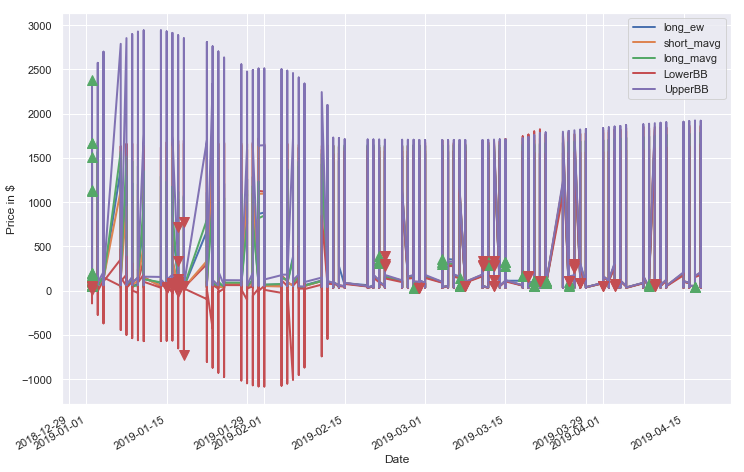

In [70]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1,  ylabel='Price in $')
df['Close'].plot(ax=ax1, color='r', lw=2.)  #Closing Price
signals[['long_ew','short_mavg','long_mavg','LowerBB','UpperBB']].plot(ax=ax1, lw=2.)  #Plotting the indicators


#Buy signals
         
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.long_ew[signals.positions == 1.0],
         '^', markersize=10, color='g',label=df['Ticker'])  

ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='g',label=df['Ticker'])

ax1.plot(signals.loc[signals.positions == 1.0].index, 
         df.UpperBB[signals.positions == 1.0],
         '^', markersize=10, color='g',label=df['Ticker'])
         
# Sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.long_ew[signals.positions == -1.0],
         'v', markersize=10, color='r',label=df['Ticker'])

ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='r',label=df['Ticker'])

ax1.plot(signals.loc[signals.positions == -1.0].index, 
         df.LowerBB[signals.positions == -1.0],
         'v', markersize=10, color='r',label=df['Ticker'])
         



plt.show()

Lassso and ridge

In [9]:
# Setting the initial capital
initial_capital= float(100000.0)
positions = pd.DataFrame(index=signals.index).fillna(0.0)
for ticker in signals['Tickers']:
    
    positions[ticker] = 100*signals['signal']        # Buying 100 shares
  
    portfolio = positions.multiply(df['Adj Close'], axis=0)    # Initial Portfolio  
    pos_diff = positions.diff() 
    portfolio['holdings'] = (positions.multiply(df['Adj Close'], axis=0)).sum(axis=1)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(df['Adj Close'], axis=0)).sum(axis=1).cumsum()   
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    signals['returns'] = portfolio['returns']
    

portfolio

,MSFT,AAPL,GOOGL,TSLA,AMZN,CCL,EBAY,FB,UPS,USB,TWTR,PYPL,HON,SO,PG,NKE,holdings,cash,total,returns
Date,,,,,,,,,,,,,,,,,,,,
2019-02-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,NaN
2019-02-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000
2019-02-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100000.000000,100000.000000,0.000000


In [12]:
portfolio['cash']

Date
2019-02-14    100000.000000
2019-02-15    100000.000000
2019-02-19    100000.000000
2019-02-20    100000.000000
2019-02-21    100000.000000
2019-02-22    100000.000000
2019-02-25    100000.000000
2019-02-26    100000.000000
2019-02-27    100000.000000
2019-02-28    100000.000000
2019-03-01    100000.000000
2019-03-04    100000.000000
2019-03-05    100000.000000
2019-03-06    100000.000000
2019-03-07    100000.000000
2019-03-08    100000.000000
2019-03-11    100000.000000
2019-03-12    100000.000000
2019-03-13    100000.000000
2019-03-14    100000.000000
2019-03-15    100000.000000
2019-03-18    100000.000000
2019-03-19    100000.000000
2019-03-20    100000.000000
2019-03-21    100000.000000
2019-03-22    100000.000000
2019-03-25    100000.000000
2019-03-26    100000.000000
2019-03-27    100000.000000
2019-03-28    100000.000000
                  ...      
2019-03-08    388880.722046
2019-03-11    388880.722046
2019-03-12    388880.722046
2019-03-13    388880.722046
2019-03-14    3

In [10]:
portfolio['returns'].sum()

1.7112957259509634

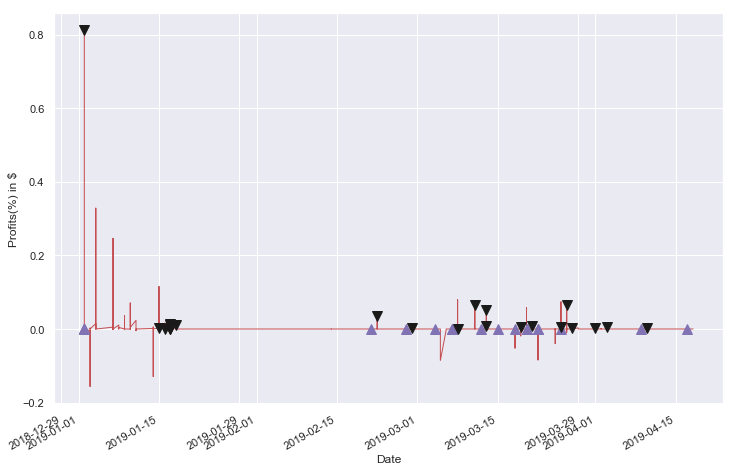

In [75]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111, ylabel='Profits(%) in $')

signals['returns'].plot(ax=ax1, color='r', lw=1.)

# Placing markers for our position entry
ax1.plot(signals.loc[signals.positions == 1.0].index,
    signals.returns[signals.positions == 1.0],
    '^', markersize=10, color='m')

# Placing markers for our position exit

ax1.plot(signals.loc[signals.positions == -1.0].index,
    signals.returns[signals.positions == -1.0],
    'v', markersize=10, color='k')

plt.show()

In [76]:

winners=signals.groupby(['Tickers']).idxmax()['returns']

winners

Tickers
AAPL    2019-01-02
AMZN    2019-01-02
CCL     2019-01-04
EBAY    2019-01-04
FB      2019-01-02
GOOGL   2019-01-02
HON     2019-01-02
MSFT    2019-02-15
NKE     2019-01-04
PG      2019-01-02
PYPL    2019-01-02
SO      2019-01-08
TSLA    2019-01-04
TWTR    2019-01-04
UPS     2019-01-04
USB     2019-01-04
Name: returns, dtype: datetime64[ns]

### I added the code for getting all the tickers from S&P500. However, I decided to use 15 tickers since the whole data from S&P 500 slows down the code significantly 
* Source in the appendix



In [ ]:


def sp500():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[1].text
        tickers.append(ticker)
    with open("sp500tickers.pickle", "wb") as f:
        pickle.dump(tickers, f)
    return tickers


sp500()
def getfrom_iex(reload_sp500=False):
    if reload_sp500:
        tickers=save_sp500_tickers()
    else:
        with open('sp500tickers.pickle','rb') as f:
            
            tickers=pickle.load(f)
        
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
    start=dt.datetime(2018,12,1)
    end=dt.datetime.today()
    for ticker in tickers:
        print(ticker)
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            df=web.DataReader(ticker,'iex',start,end)
            df.to_csv('stock_dfs/{}.csv'.format(ticker))
        else: 
            pass
getfrom_iex() 

file_names = glob.glob(os.path.join(os.getenv("HOME"), "stock_dfs","*.csv"))
short_file_names = [os.path.basename(file) for file in file_names]
tickers = [file.split(".")[0] for file in short_file_names]
tickers

                                          Appendix
[Python Programming link](https://pythonprogramming.net/getting-stock-prices-python-programming-for-finance/)